# Diffusion Model from Scracth
This was used as a source for some parts: https://colab.research.google.com/drive/1sjy9odlSSy0RBVgMTgP7s99NXsqglsUL?usp=sharing#scrollTo=KOYPSxPf_LL7

**Libraries**

In [90]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms 
from torch.utils.data import DataLoader
import math
import numpy as np

In [99]:
device = "cuda" if torch.cuda.is_available() else "mps"
BATCH_SIZE = 32

**Dataset**

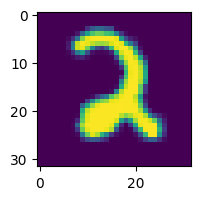

In [100]:
def create_mnist_dataloaders(batch_size,image_size=32,num_workers=4):
    
    preprocess = transforms.Compose([
        transforms.Resize(image_size),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])
    train_dataset=torchvision.datasets.MNIST(root="./mnist_data",train=True,download=True,transform=preprocess)
    test_dataset=torchvision.datasets.MNIST(root="./mnist_data",train=False,download=True,transform=preprocess)

    combined_dataset = torch.utils.data.ConcatDataset([train_dataset,test_dataset])

    return DataLoader(combined_dataset,batch_size=batch_size,shuffle=True)

dataloader = create_mnist_dataloaders(BATCH_SIZE)

plt.figure(figsize=(2,2))
plt.imshow(next(iter(dataloader))[0][0][0])

**Forward Noise Scheduler**

In [101]:
def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start,end,timesteps)

def get_index_from_list(vals, t, x_shape):
    batch_size = t.shape[0]
    out = vals.gather(-1,t.cpu())
    return out.reshape(batch_size,*((1,)*(len(x_shape)-1))).to(device)

def forward_diffusion_sample(x_0, t):
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)

T = 300
betas = linear_beta_schedule(timesteps=T)

# precacluation to use the direct method to go to any T rather than doing it sequentially
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas,axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1],(1,0),value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0/alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0-alphas_cumprod)
posterior_variance = betas*(1.0-alphas_cumprod_prev)/(1.0-alphas_cumprod)

**Testing the noise scheduler**

/var/folders/y_/g46v5wcs2mlg96p8tytg8l7m0000gn/T/ipykernel_26007/4090459923.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,num_images+1,int(idx/stepsize)+1)


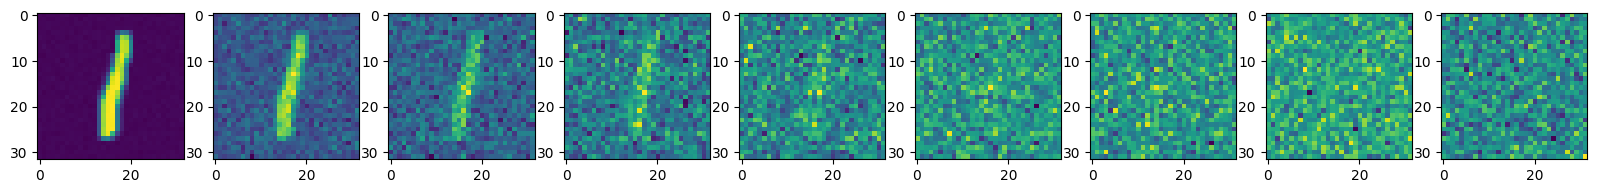

In [103]:
image = next(iter(dataloader))[0][0][0]

plt.figure(figsize=(20,20))
plt.axis('off')
num_images = 8
stepsize = int(T/num_images)

for idx in range(0,T,stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1,num_images+1,int(idx/stepsize)+1)
    image, noise = forward_diffusion_sample(image,t)
    plt.imshow(image.cpu())

In [104]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        
    def forward(self, x, t, ):
        h = self.bnorm1(self.relu(self.conv1(x)))
        time_emb = self.relu(self.time_mlp(t))
        time_emb = time_emb[(..., ) + (None, ) * 2]
        h = h + time_emb
        h = self.bnorm2(self.relu(self.conv2(h)))
        return self.transform(h)

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings
    
class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (32, 64, 128, 256, 512)
        up_channels = (512, 256, 128, 64, 32)
        out_dim = 3
        time_emb_dim = 16

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        
        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])
        
        # Edit: Corrected a bug found by Jakub C (see YouTube comment)
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        return self.output(x)

In [105]:
model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))

Num params:  15615987


In [106]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :] 
    plt.imshow(reverse_transforms(image))


@torch.no_grad()
def sample_timestep(x, t):
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    
    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 
    
@torch.no_grad()
def sample_plot_image():
    # Sample noise
    img_size = 32
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            show_tensor_image(img.detach().cpu())
    plt.show()            

Epoch 0 | step 000 Loss: 0.8142864108085632 


/var/folders/y_/g46v5wcs2mlg96p8tytg8l7m0000gn/T/ipykernel_26007/95381549.py:55: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images, int(i/stepsize)+1)


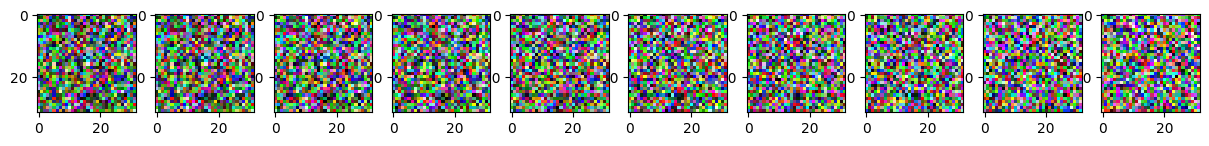

RuntimeError: The size of tensor a (32) must match the size of tensor b (16) at non-singleton dimension 0

In [107]:
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 100 # Try more!

for epoch in range(epochs):
    for step, full in enumerate(dataloader):
      batch, labels = full

      optimizer.zero_grad()
      t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
      loss = get_loss(model, batch, t)
      loss.backward()
      optimizer.step()

      if epoch % 5 == 0 and step == 0:
        print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
        sample_plot_image()